 # Contextual bandits
 In this notebook, we implement the contextual bandit algorithm

In [17]:
import numpy as np
from math import sqrt, log
from matplotlib import pyplot as plt
from numpy.random import default_rng
random = default_rng()
from tqdm import tqdm
from functools import partial
from sklearn.linear_model import Lasso

## Parameters and functions

In [22]:
n_arms= 50
dim = 10
horizon = 1000
l_reg = 1

theta =  (2*random.random(dim)-1)/dim

# The next 3 lines only concern the sparse case
sparsity = 10
inds_to_zero = np.random.choice(range(dim), size= dim - sparsity, replace= False)
theta[inds_to_zero] = 0.0



def contextual_bandit_experiment(horizon, dim, context_generator, l_reg, policy_with_args, is_inverse_V, 
                                 update_V_like, theta_estim= None):
    action = [] #action,
    reward = [] # realized reward
    expected_reward = [] # expectation of realized reward given the selected action
    oracle_expected_reward = []
    if is_inverse_V:
        V_like = 1/l_reg*np.eye(dim)
    else:
        V_like = np.zeros((dim,dim))
    
    b = np.zeros(dim)
    for t in tqdm(range(1, horizon+1)):
        # generate a set of contexts
        #X = (2*random.random((n_arms,dim))-1)/dim
        X = next(context_generator)
        oracle_reward_pool = X @ theta
        #y = oracle_reward_pool+ random.normal(0,1, n_arms) # removed as not all the noise is needed
        
        # select action
        
        action_played = policy_with_args(X, b, V_like, theta_estim, t)
        
        x_played = X[action_played]
        y_played = oracle_reward_pool[action_played] + random.normal(0,1)
        
        
        # Update estimated theta
        V_like = update_V_like(V_like, x_played) # Sherman-Morrison formula to update the inverse
        b += y_played*x_played

        # Store history for plotting
        action.append(action_played)
        expected_reward.append(theta @ x_played)
        oracle_expected_reward.append(np.max(oracle_reward_pool))

    return np.array(expected_reward), np.array(oracle_expected_reward)

## Ridge regression case

### Simple case: one experiment

In [23]:
def LinUCB(X, b, V_like, theta_estim, t, l, delta):
    """
        theta_estim is a dummy argument for coherence, serves as initialization for other estimation methods 
    """
    sqrtbeta = sqrt(l) + sqrt(2*log(1/delta)+dim*log(1+t/(dim*l)))
    radius = sqrtbeta * np.sqrt(np.einsum("ij,jk,ik->i", X, V_like, X))
    ucb = X @ V_like @ b + radius
    return np.argmax(ucb)

# def LinUCB_adaptive(theta_estim, invV, t, l, delta):
#     beta = sqrt(l) + sqrt(2*log(1/delta)+dim*log(1+t/(dim*l)))
#     radius = np.sqrt(beta * np.einsum("ij,jk,ik->i", [X, invV, X]))
#     ucb = X @ theta_estim + radius
#     return np.argmax(ucb)
def update_invV(invV, x):
    invV_x= invV @ x
    invV -= np.outer(invV_x, invV_x)/(1 + x @ invV_x)
    return invV

def random_context_generator(horizon, dim, n_arms, theta):
    for _ in range(horizon):
        yield random.multivariate_normal(np.ones(dim), np.eye(dim), n_arms)

context_generator = random_context_generator(horizon, dim, n_arms, theta)


policy_with_args = partial(LinUCB, l= l_reg, delta= 0.1)
expected_reward, oracle_expected_reward = contextual_bandit_experiment(horizon, dim, context_generator, 
                                                                         l_reg, policy_with_args, True, update_invV)

100%|██████████| 1000/1000 [00:00<00:00, 2843.02it/s]


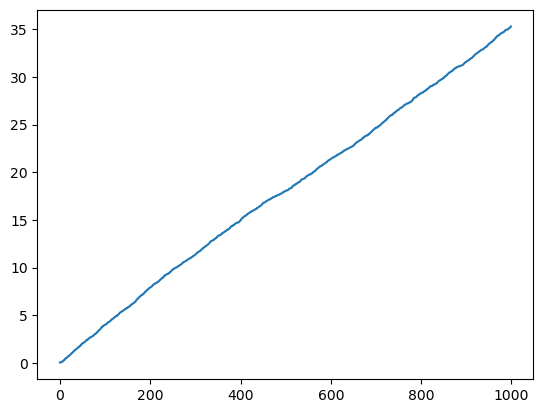

In [15]:
agentCumulExpecReward = np.cumsum(expected_reward)
oraclCumulReward = np.cumsum(oracle_expected_reward)
meanRegret = (oraclCumulReward - agentCumulExpecReward)

plt.figure()
plt.plot(meanRegret)

### Two arms, multiple simulations

In [24]:
# bandit instance
reps = 50
action = [] #action
reward = [] # realized reward
expected_reward = [] # expectation of realized reward given the selected action
oracle_expected_reward = []
theta_estim_error = []


#xMean = np.zeros((2, horizon))
invV = np.einsum("ij,k->ijk", 1/l_reg*np.eye(dim), np.ones(reps))
b = np.zeros((dim,reps))
# Initialization: pull each arm once
# for k in range(n_arms):
#     action[k] = k
#     reward[k] = random.binomial(1,mu_vec[action[k]])
# theta_estim = np.zeros(dim)

def LinUCB(expec_estim_rewards, X, invV, t, l, delta):
    sqrtbeta = sqrt(l) + sqrt(2*log(1/delta)+dim*log(1+t/(dim*l)))
    radius = sqrtbeta * np.sqrt(np.einsum("ij,jkl,ik->il", X, invV, X))
    ucb = expec_estim_rewards + radius
    return np.argmax(ucb, axis= 0)

def update_invV(invV, x):
    invV_x = np.einsum("ijk, jk -> ik", invV , x)
    invV -= np.einsum("ik,jk -> ijk", invV_x, invV_x)/(1 + np.einsum("ik,ik->k", x, invV_x)[None,None,:])
    return invV

# def LinUCB_adaptive(theta_estim, invV, t, l, delta):
#     beta = sqrt(l) + sqrt(2*log(1/delta)+dim*log(1+t/(dim*l)))
#     radius = np.sqrt(beta * np.einsum("ij,jk,ik->i", [X, invV, X]))
#     ucb = X @ theta_estim + radius
#     return np.argmax(ucb)
for t in tqdm(range(1, horizon+1)):
    # generate a set of contexts
    # X = (2*random.random((n_arms,dim))-1)/dim
    X = random.multivariate_normal(np.ones(dim), np.eye(dim), n_arms)
    oracle_reward_pool = X @ theta
    
    # the context set characterizes the bandit instance, hence it does not vary through repetitionns
    #y = oracle_reward_pool[:,None]+ random.normal(0,1, (n_arms,reps))
    #print(f"shape of y is {y.shape}")
    
    # select action
    theta_estim = np.einsum("ijk,jk->ik", invV, b)
    expec_estim_rewards = X @ theta_estim
    #action_played = np.argmax(X @ theta_estim, axis= 0)
    action_played = LinUCB(expec_estim_rewards, X, invV, t, l_reg, 0.9)
    
    x_played = X[action_played].T
    y_played = oracle_reward_pool[action_played] + random.standard_normal(reps)
    
    # Update estimated theta
    invV = update_invV(invV, x_played)
    b += y_played*x_played

    # Store history for plotting
    action.append(action_played)
    expected_reward.append(theta @ x_played)
    oracle_expected_reward.append(np.max(oracle_reward_pool))
    theta_estim_error.append(np.linalg.norm(theta[:,None]-theta_estim, axis= 0))

expected_reward = np.array(expected_reward)
oracle_expected_reward = np.array(oracle_expected_reward)
theta_estim = np.array(theta_estim_error)

100%|██████████| 1000/1000 [00:00<00:00, 1218.04it/s]


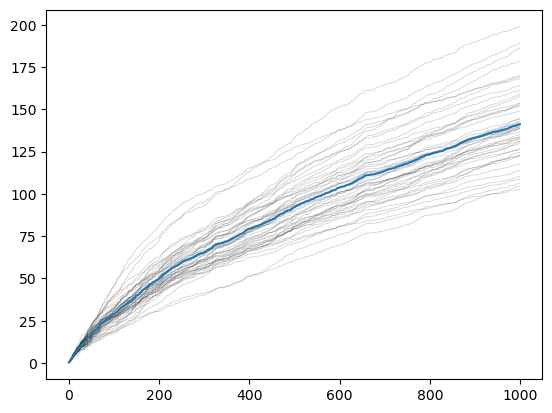

In [25]:
agentCumulExpecReward = np.cumsum(expected_reward, axis= 0)
oraclCumulReward = np.cumsum(oracle_expected_reward, axis= 0)
meanRegret = (oraclCumulReward[:,None] - agentCumulExpecReward)

plt.figure()
plt.plot(meanRegret, 'k', alpha= 0.2, linewidth= 0.5);
plt.plot(meanRegret.mean(axis= 1))


## Lasso regression

### Simple case with one repetition

In [58]:
def solve_lasso(V, b, l, theta_estim):
    "We use the ISTA algorithm"
    lr = 1/np.linalg.norm(V, ord= 2)
    value_ista = []
        
    err = np.inf
    n= len(b)
    value = 0.5/n*(theta_estim @ V - b) @ theta_estim + l*np.linalg.norm(theta_estim, ord= 1)
    i= 0
    while err > 1e-6 and i < 100:
        grad = (V @ theta_estim- b)# the gradient of the L1 regularization is not taken
        theta_estim -= lr*grad
        theta_estim -= np.clip(theta_estim, -lr*l, lr*l)
        value_new = 0.5/n*(theta_estim @ V - b) @ theta_estim + l*np.linalg.norm(theta_estim, ord= 1)
        err = np.abs(value_new-value)/value
        i += 1
    return theta_estim

def LA_Lasso(X, b, V, theta_estim, t, l, dim):
    """ implementation of the policy from Oh et al 2021
    """
    l_t = l*sqrt((4*log(t) + 2*log(dim))/t)
    theta_estim = solve_lasso(V, b, l, theta_estim)
    return np.argmax(X @ theta_estim) # greedy policy

update_V = lambda V, x: V + np.outer(x,x)

def random_context_generator(horizon, dim, n_arms, theta):
    for _ in range(horizon):
        yield random.multivariate_normal(np.ones(dim), np.eye(dim), n_arms)

context_generator = random_context_generator(horizon, dim, n_arms, theta)


policy_with_args = partial(LA_Lasso, l= l_reg, dim= len(theta))
expected_reward, oracle_expected_reward = contextual_bandit_experiment(horizon, dim, context_generator, 
                                                                        l_reg, policy_with_args, True, update_V, random.random(dim))

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_71397/1428783815.py:15: RuntimeWarning: invalid value encountered in double_scalars
  err = np.abs(value_new-value)/value
/tmp/ipykernel_71397/1428783815.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  err = np.abs(value_new-value)/value
100%|██████████| 1000/1000 [00:16<00:00, 60.57it/s]


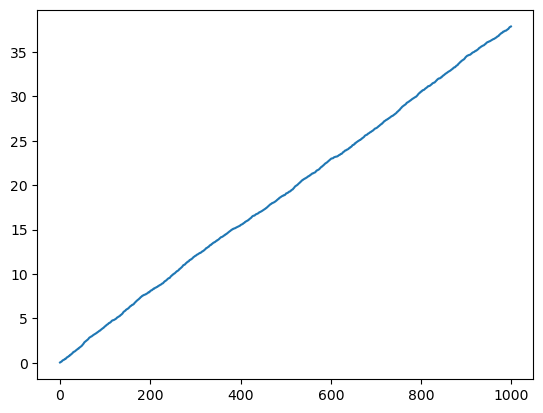

In [59]:
agentCumulExpecReward = np.cumsum(expected_reward)
oraclCumulReward = np.cumsum(oracle_expected_reward)
meanRegret = (oraclCumulReward - agentCumulExpecReward)

plt.figure()
plt.plot(meanRegret)
